# üèÅ Pole to Podium: How F1 Champions Are Made

**QTM¬†151: Introduction to Statistical Computing II ‚Äî Final Project**

In [809]:
# Print Names
team_members = [
    "Amanda Middelthon",
    "Anika Chandra",
    "Cassiel Chen",
    "Tianyi Zhang"
]


decorative_line = "~" * 60
print(decorative_line)
print("üåä TEAM MEMBERS üåä".center(60))
print(decorative_line)
for member in team_members:
    print(f"~ {member.center(56)} ~")
print(decorative_line)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                      üåä TEAM MEMBERS üåä                      
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~                    Amanda Middelthon                     ~
~                      Anika Chandra                       ~
~                       Cassiel Chen                       ~
~                       Tianyi Zhang                       ~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## Section 1: Introduction

Formula 1 (F1) is the world‚Äôs premier open-wheel racing series, where cutting-edge engineering, peak athlete performance, and split-second strategy collide. Since its inaugural season in 1950, F1 has grown into a truly global spectacle‚Äîspanning five continents and challenging drivers on a dizzying array of circuits, from high-altitude mountain tracks to tight street courses. Fans and analysts alike follow every qualifying session, pit stop and photo finish on [Formula1.com](https://www.formula1.com/) and in encyclopedic resources such as [Wikipedia‚Äôs Formula One page](https://en.wikipedia.org/wiki/Formula_One).

![Modern F1 Race Car](https://cdn.ferrari.com/cms/network/media/img/resize/5e5789ba4125497a8dd90672-ferrari-scuderia-f1-2020-galleries-hero-desk?width=1080)  
*Figure 1: A modern Ferrari F1 car in action*

We‚Äôre interested not just in who wins, but **where** and **how** those victories happen‚Äîand how the sport has become more (or less) geographically diverse over time. To that end, we‚Äôll answer three focused questions:

1. **RQ1: Which race consistently has the most accidents & incompletes?**  
   - **Why?** F1 racing in itself is a very high-risk sport, and by analyzing which races have been the most risky, we will gain insight into the risk factors that could have caused it.  
   - **Tables:** `Drivers`, `Results`  
   - **Approach:** Join `drivers.driverId ‚Üí results.driverId`, cast `positionOrder` to integer, flag `podium = (positionOrder ‚â§ 3)`, and count podiums by `nationality`.

2. **RQ2: What are the locations with consistently the fastest time (or lap)? **  
   - **Why?** Circuit layout, elevation and length all impact lap speeds and race pace‚Äîcomparing these metrics highlights which tracks are genuinely fast versus those that reward endurance and strategy.  
   - **Tables:** `Results`, `Circuits`, `Status`  
   - **Approach:** Filter to classified finishers (`status == "Finished"` or matches `"+n Laps"`), convert `milliseconds` and `fastestLapTime` into seconds, then compute per-circuit averages and finisher counts.

3. **RQ3: How has each nationality‚Äôs podium-rate evolved over the decades?**  
   - **Why?** Charting podium success against driver debut decades uncovers shifts in global competitiveness and emerging talent markets‚Äîrevealing when and where new national programs broke through.  
   - **Tables:** `Drivers`, `Results`, `Races`  
   - **Approach:** Merge `results.raceId ‚Üí races.raceId` to pull race dates, derive each driver‚Äôs `debut_decade` from their first appearance, flag podiums, and compute podium-rates (podiums √∑ entries) by `nationality` and decade.

---

We will first load and inspect these tables (Section 2), then perform the cleaning, merging, and calculations needed for each question (Section 3), and conclude with an interpretation of our findings (Section 4).


## Section 2: Data Description

For our analysis, we are focusing on a curated subset of the comprehensive Formula 1 dataset, which comprises 14 tables. We have selected five tables‚Äî**Drivers**, **Races**, **Results**, **Circuits**, and **Status**‚Äîbecause they offer a multi-dimensional view of the sport and allow us to filter for classified finishers where needed.

- **Drivers**: Each row represents a unique Formula 1 driver and includes essential details such as the driver's name, nationality, and date of birth. This table provides the backbone for understanding personal attributes and backgrounds.

- **Races**: Captures the details of every race event‚Äîrace date, round, season, and circuit linkage‚Äîspanning the sport‚Äôs evolution. We use it to derive decade-of-debut and to join race-level metadata.

- **Results**: Records each driver‚Äôs performance in a given race: starting grid, finishing position (`positionOrder`), points, lap counts, total race time (`milliseconds`), fastest lap details, and a `statusId`. This is the core table for our performance, podium, and speed analyses.

- **Circuits**: Describes each race venue‚Äîits name, location, country, and altitude‚Äîenabling us to examine how track characteristics affect average race and lap times.

- **Status**: Maps `statusId` to finishing status strings (e.g., ‚ÄúFinished‚Äù, ‚ÄúAccident‚Äù, ‚Äú+1 Lap‚Äù). We join this to **Results** to distinguish true finishers from DNFs or technical retirements, ensuring our circuit-speed calculations and podium denominators are based only on classified outcomes.


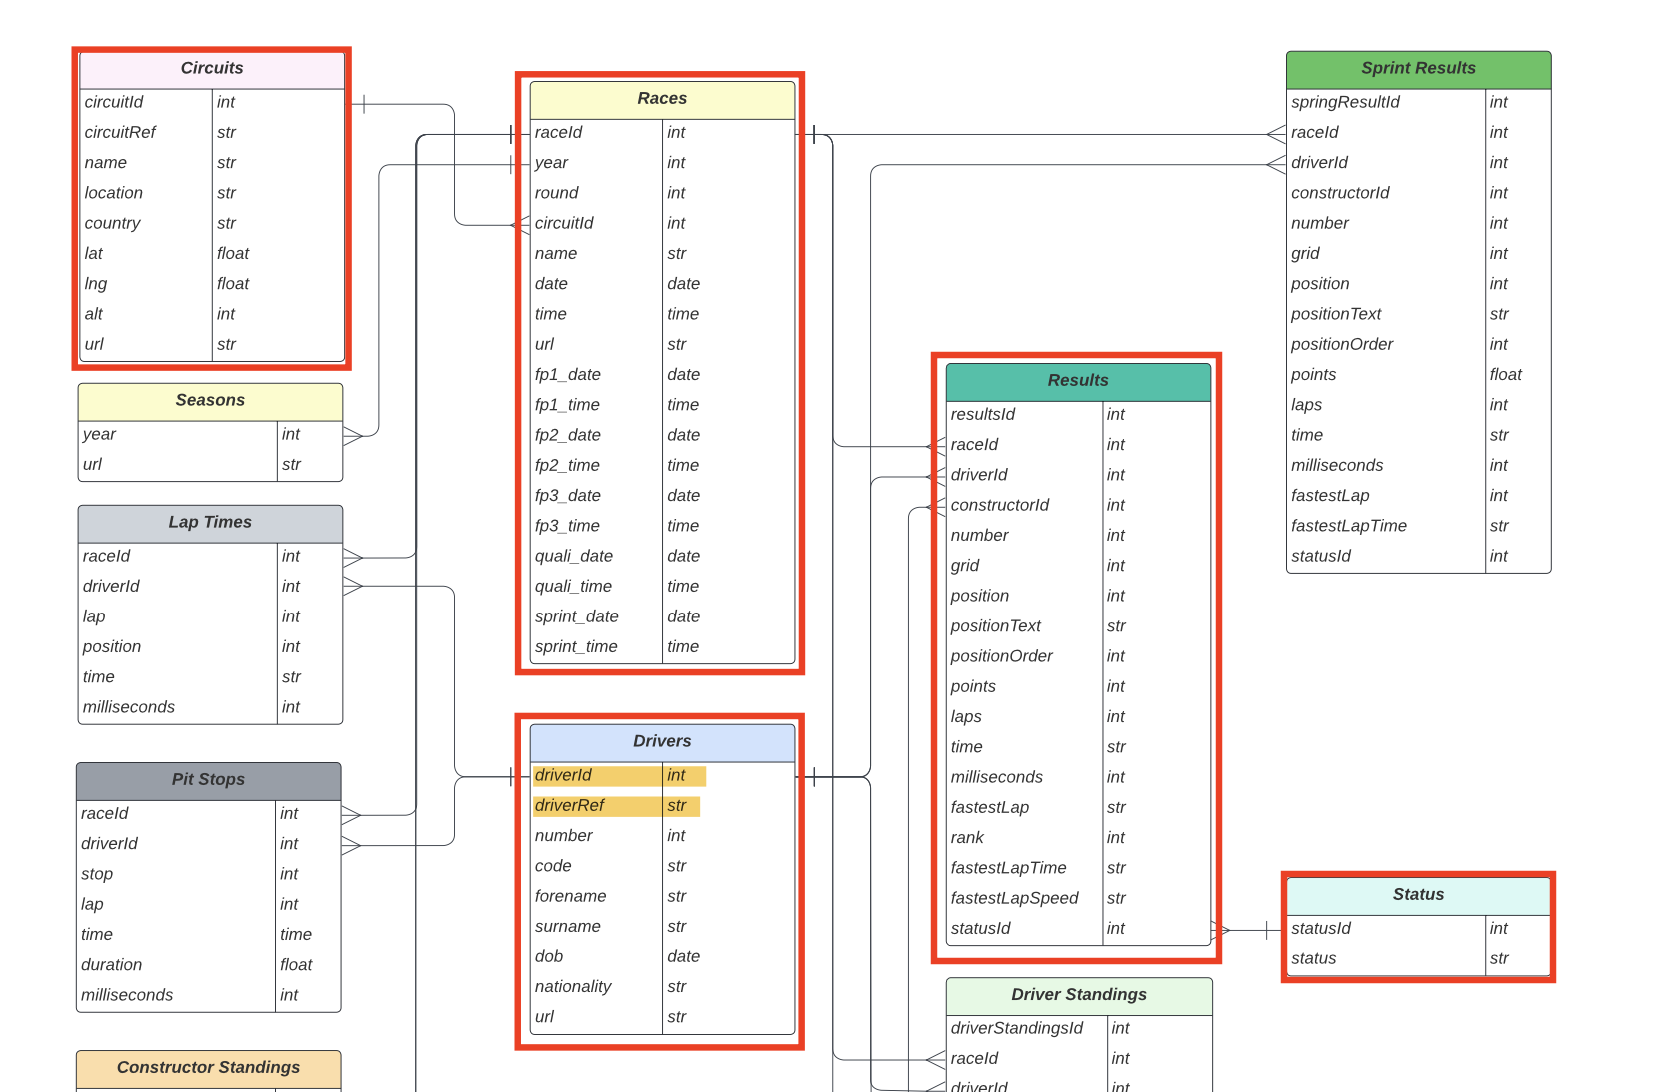


### 2.1 Library Imports and Directory Setup

Before beginning our analysis, we need to import several Python libraries that will help us manipulate data, perform numerical computations, and create visualizations. We also set up our environment by determining the current working directory and specifying the subfolder (`data_raw`) where our raw data is stored. 

- **Pandas** enables efficient data manipulation with its DataFrame objects.
- **NumPy** is used for handling numerical operations and computations.
- **Matplotlib** and **Seaborn** assist in creating both simple and complex visualizations.
- **OS** helps us interact with the operating system to manage file paths.

Below is the code snippet that imports these libraries, configures our plotting settings, and sets the directory for our raw data.


In [810]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'data_raw')

# print("Current working directory:", current_dir)
# print("Data directory:", data_dir)

### 2.2 Loading Datasets and Counting Observations

In this section, we load the selected Formula 1 datasets from our specified `data_raw` directory. We work with four key tables:

- **Drivers**: Contains information about each driver, such as name, nationality, and date of birth.
- **Races**: Records details of every race event, including the race date, round, and season.
- **Results**: Provides performance metrics for drivers in each race, such as finishing positions and points scored.
- **Circuits**: Holds details about the race circuits, including circuit name, location, and geographic coordinates.

The following code snippet reads each dataset from its corresponding CSV file and prints out the number of rows to ensure that the data has loaded correctly.


In [811]:
# Load the datasets and count the number of observations in each


drivers = pd.read_csv(os.path.join(data_dir, 'drivers.csv'))
races = pd.read_csv(os.path.join(data_dir, 'races.csv'))
results = pd.read_csv(os.path.join(data_dir, 'results.csv'))
circuits = pd.read_csv(os.path.join(data_dir, 'circuits.csv'))
status = pd.read_csv(os.path.join(data_dir, 'status.csv'))


for df, name in [(drivers, "Drivers"), (races, "Races"),
                 (results, "Results"), (circuits, "Circuits"),
                 (status, "Status")]:
    print(f"{name}: {df.shape[0]} rows √ó {df.shape[1]} cols")
    display(df.head(2))


Drivers: 857 rows √ó 9 cols


driverId driverRef number code forename   surname         dob nationality  \
0         1  hamilton     44  HAM    Lewis  Hamilton  1985-01-07     British   
1         2  heidfeld     \N  HEI     Nick  Heidfeld  1977-05-10      German   

                                           url  
0  http://en.wikipedia.org/wiki/Lewis_Hamilton  
1   http://en.wikipedia.org/wiki/Nick_Heidfeld

Races: 1102 rows √ó 18 cols


raceId  year  round  circuitId                   name        date  \
0       1  2009      1          1  Australian Grand Prix  2009-03-29   
1       2  2009      2          2   Malaysian Grand Prix  2009-04-05   

       time                                                url fp1_date  \
0  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   
1  09:00:00  http://en.wikipedia.org/wiki/2009_Malaysian_Gr...       \N   

  fp1_time fp2_date fp2_time fp3_date fp3_time quali_date quali_time  \
0       \N       \N       \N       \N       \N         \N         \N   
1       \N       \N       \N       \N       \N         \N         \N   

  sprint_date sprint_time  
0          \N          \N  
1          \N          \N

Results: 25840 rows √ó 18 cols


resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0         39    2       1:27.452         218.300         1  
1         41    3       1:27.739         217.586         1

Circuits: 77 rows √ó 9 cols


circuitId   circuitRef                            name      location  \
0          1  albert_park  Albert Park Grand Prix Circuit     Melbourne   
1          2       sepang    Sepang International Circuit  Kuala Lumpur   

     country       lat      lng alt  \
0  Australia -37.84970  144.968  10   
1   Malaysia   2.76083  101.738  18   

                                                 url  
0  http://en.wikipedia.org/wiki/Melbourne_Grand_P...  
1  http://en.wikipedia.org/wiki/Sepang_Internatio...

Status: 139 rows √ó 2 cols


statusId        status
0         1      Finished
1         2  Disqualified

### 2.3 'Drivers' Dataset Exploration

Table Schema

| Field         | Type           | Null | Key | Default | Description                           |
|--------------:|:---------------|:-----|:----|:--------|:--------------------------------------|
| `driverId`    | `int(11)`      | NO   | PRI | ‚Äî       | Primary key (auto-increment)          |
| `driverRef`   | `varchar(255)` | NO   |     | ‚Äî       | Unique driver identifier              |
| `number`      | `int(11)`      | YES  |     | ‚Äî       | Permanent driver number               |
| `code`        | `varchar(3)`   | YES  |     | ‚Äî       | Driver code (e.g. ‚ÄúALO‚Äù)              |
| `forename`    | `varchar(255)` | NO   |     | ‚Äî       | Driver forename                       |
| `surname`     | `varchar(255)` | NO   |     | ‚Äî       | Driver surname                        |
| `dob`         | `date`         | YES  |     | ‚Äî       | Driver date of birth                  |
| `nationality` | `varchar(255)` | YES  |     | ‚Äî       | Driver nationality                    |
| `url`         | `varchar(255)` | NO   | UNI | ‚Äî       | Wikipedia page (unique)               |

The **Drivers** table contains one row per F1 competitor (857 entries). The `driverId` field serves as the internal primary key, while `driverRef` uniquely identifies each driver externally. Permanent race numbers (`number`) and three-letter codes (`code`) are provided when available. Both `forename` and `surname` are required, ensuring clear naming, whereas `dob` and `nationality` may be null if unknown. Finally, the `url` column links to each driver‚Äôs Wikipedia page, offering a reliable reference for further biographical details. This schema gives us all the demographic and identity information needed for our nationality-based analyses.  

#### Data Exploration

The **Drivers** dataset contains information for each unique Formula 1 driver, such as their name, nationality, and date of birth. In the code below, we display the first five rows, the detailed dataset information (data types and non-null counts), and summary statistics to understand the structure and composition of the data.


In [812]:
# Preview the first 5 rows of the Drivers dataset
print("Drivers dataset loaded with", drivers.shape[0], "rows.")
print("First 5 Rows of the Drivers Dataset:")
print(drivers.head())

Drivers dataset loaded with 857 rows.
First 5 Rows of the Drivers Dataset:
   driverId   driverRef number code  forename     surname         dob  \
0         1    hamilton     44  HAM     Lewis    Hamilton  1985-01-07   
1         2    heidfeld     \N  HEI      Nick    Heidfeld  1977-05-10   
2         3     rosberg      6  ROS      Nico     Rosberg  1985-06-27   
3         4      alonso     14  ALO  Fernando      Alonso  1981-07-29   
4         5  kovalainen     \N  KOV    Heikki  Kovalainen  1981-10-19   

  nationality                                             url  
0     British     http://en.wikipedia.org/wiki/Lewis_Hamilton  
1      German      http://en.wikipedia.org/wiki/Nick_Heidfeld  
2      German       http://en.wikipedia.org/wiki/Nico_Rosberg  
3     Spanish    http://en.wikipedia.org/wiki/Fernando_Alonso  
4     Finnish  http://en.wikipedia.org/wiki/Heikki_Kovalainen  


Above is a snapshot of the first five rows from the Drivers dataset, which comprises 857 records in total. Each row represents a unique Formula 1 driver and includes key information such as the internal driver ID, an external reference, the driver's racing number (which may be absent in some cases), a short driver code, first name, last name, date of birth, nationality, and a URL linking to their Wikipedia page. For instance, the first entry in this dataset corresponds to Lewis Hamilton, one of the sport‚Äôs most celebrated figures. To honor his legacy, we also include an image of him below.

![Lewis Hamilton](https://media.formula1.com/image/upload/f_auto,c_limit,q_auto,w_1320/content/dam/fom-website/drivers/2025Drivers/hamilton)
*Figure 3: Picture of Lewis Hamilton - F1 Driver for Ferrari*

In [813]:
# Display dataset information
print("Dataset Information:")
drivers.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857 entries, 0 to 856
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   driverId     857 non-null    int64 
 1   driverRef    857 non-null    object
 2   number       857 non-null    object
 3   code         857 non-null    object
 4   forename     857 non-null    object
 5   surname      857 non-null    object
 6   dob          857 non-null    object
 7   nationality  857 non-null    object
 8   url          857 non-null    object
dtypes: int64(1), object(8)
memory usage: 60.4+ KB


Every column in the **Drivers** table is fully populated, with no missing rows. The only integer field, `driverId`, serves as our primary key for all merges. The other eight columns are stored as strings (or dates once converted), covering identifiers (`driverRef`), personal details (`forename`, `surname`, `dob`, `nationality`), race metadata (`number`, `code`), and reference links (`url`). Several of these‚Äîparticularly `number`, `code`, `dob`, and `nationality`‚Äîuse the placeholder `"\N"` for missing entries. In the next step we‚Äôll replace `"\N"` with `NaN` and cast each column to its proper type so that null values are handled correctly in our analyses.  


> **Note on Summary Statistics:** Running a summary statistics table on the **Drivers** table would yield little insight because most fields are unique IDs or high‚Äêcardinality strings. Instead, we‚Äôll generate two focused summaries that directly inform our analysis: a nationality frequency table to show which countries are most represented on the grid and a count of how many drivers have a permanent `number` versus missing entries, revealing how many carry a fixed race number.  


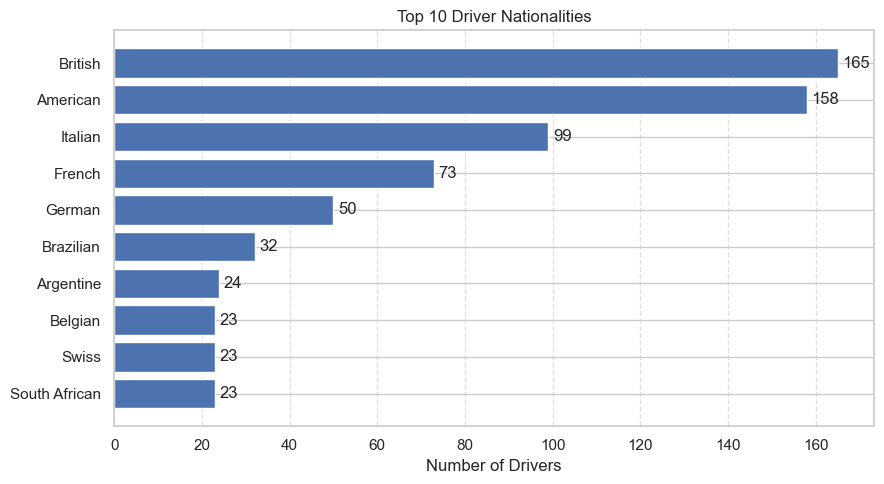

In [814]:
import matplotlib.pyplot as plt


nat_counts = drivers['nationality'].value_counts()
top_nat = nat_counts.head(10)

plt.figure(figsize=(9, 5))
bars = plt.barh(top_nat.index[::-1], top_nat.values[::-1])
plt.xlabel('Number of Drivers')
plt.title('Top 10 Driver Nationalities')
plt.grid(axis='x', linestyle='--', alpha=0.6)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2, str(int(width)), va='center')

plt.tight_layout()
plt.show()


This chart shows the all-time headcount of Formula 1 drivers by nationality. The U.K. tops the list with 165 drivers, narrowly ahead of the U.S. at 158‚Äîunderscoring both countries‚Äô deep motorsport infrastructures and feeder series. Italy (99) and France (73) follow as the next most prolific talent pools, with Germany (50) rounding out the top five. Beyond Europe‚Äôs ‚ÄúBig Four,‚Äù Brazil (32) and Argentina (24) reflect South America‚Äôs rich F1 heritage, while Belgium, Switzerland, and South Africa each contributed 23 drivers. The sharp decline after the leading nations illustrates how a small group of countries has historically dominated F1‚Äôs driver pipeline.

In [815]:
# Permanent number assignment
import pandas as pd

# replace "\\N" with NaN so we can count the number of drivers with and without a permanent number
drivers['number'] = drivers['number'].replace("\\N", pd.NA)

assigned = drivers['number'].notna().sum()
missing  = drivers['number'].isna().sum()

print(f"Drivers with a permanent number: {assigned}")
print(f"Drivers without a permanent number: {missing}")


Drivers with a permanent number: 54
Drivers without a permanent number: 803


Only 54 drivers have a non-null `number` because permanent driver numbers weren‚Äôt introduced until 2014. Before then, competitors used whatever number was assigned each weekend, so all pre-2014 drivers (and any who never opted in) appear as missing (`NaN`), accounting for the 803 without a permanent number.


### 2.4 'Races' Dataset Exploration

#### Races Table Schema

From the Ergast codebook, the **races** table is defined with 18 columns:

| Field          | Type           | Null | Key | Default    | Description                                |
|---------------:|:---------------|:-----|:----|:-----------|:-------------------------------------------|
| `raceId`       | `int(11)`      | NO   | PRI | ‚Äî          | Primary key (auto-increment)               |
| `year`         | `int(11)`      | NO   |     | 0          | Championship season (e.g. 1950)            |
| `round`        | `int(11)`      | NO   |     | 0          | Sequence number within the season          |
| `circuitId`    | `int(11)`      | NO   |     | 0          | Foreign key ‚Üí `circuits.circuitId`         |
| `name`         | `varchar(255)` | NO   |     | ‚Äî          | Official race name (e.g. ‚ÄúMonaco Grand Prix‚Äù) |
| `date`         | `date`         | NO   |     | `0000-00-00` | Race date (ISO format)                     |
| `time`         | `time`         | YES  |     | ‚Äî          | Scheduled start time                       |
| `url`          | `varchar(255)` | YES  | UNI | ‚Äî          | Wikipedia link for the event               |
| `fp1_date`     | `date`         | YES  |     | ‚Äî          | Free Practice 1 date                       |
| `fp1_time`     | `time`         | YES  |     | ‚Äî          | Free Practice 1 start time                 |
| `fp2_date`     | `date`         | YES  |     | ‚Äî          | Free Practice 2 date                       |
| `fp2_time`     | `time`         | YES  |     | ‚Äî          | Free Practice 2 start time                 |
| `fp3_date`     | `date`         | YES  |     | ‚Äî          | Free Practice 3 date                       |
| `fp3_time`     | `time`         | YES  |     | ‚Äî          | Free Practice 3 start time                 |
| `quali_date`   | `date`         | YES  |     | ‚Äî          | Qualifying session date                    |
| `quali_time`   | `time`         | YES  |     | ‚Äî          | Qualifying start time                      |
| `sprint_date`  | `date`         | YES  |     | ‚Äî          | Sprint race date                           |
| `sprint_time`  | `time`         | YES  |     | ‚Äî          | Sprint race start time                     |


- The first seven fields (`raceId` through `time`) are all non-nullable and form the core metadata we need for merging and analysis.
- All session-specific fields (`fp*`, `quali*`, `sprint*`) allow NULL and are often unused in early seasons; we can ignore or clean these when focusing on main race data.

This schema confirms that our primary keys and join fields are complete and ready for the merges required by our three focused research questions.  

#### Data Exploration

The **Races** dataset captures one row per Grand¬†Prix and includes key scheduling and identification fields‚Äîsuch as `raceId`, `year`, `round`, `circuitId`, `name`, `date`, and `time`. In the code below, we display the first five rows to see the earliest events, call `.info()` to check data types and non‚Äënull counts, and use `.describe(include='all')` to review summary statistics across both numeric and categorical columns.  


In [816]:
# Preview the first 5 rows of the Races dataset
print("Races dataset loaded with", races.shape[0], "rows.")
print("First 5 Rows of the Races Dataset:")
print(races.head(), "\n")

Races dataset loaded with 1102 rows.
First 5 Rows of the Races Dataset:
   raceId  year  round  circuitId                   name        date  \
0       1  2009      1          1  Australian Grand Prix  2009-03-29   
1       2  2009      2          2   Malaysian Grand Prix  2009-04-05   
2       3  2009      3         17     Chinese Grand Prix  2009-04-19   
3       4  2009      4          3     Bahrain Grand Prix  2009-04-26   
4       5  2009      5          4     Spanish Grand Prix  2009-05-10   

       time                                                url fp1_date  \
0  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   
1  09:00:00  http://en.wikipedia.org/wiki/2009_Malaysian_Gr...       \N   
2  07:00:00  http://en.wikipedia.org/wiki/2009_Chinese_Gran...       \N   
3  12:00:00  http://en.wikipedia.org/wiki/2009_Bahrain_Gran...       \N   
4  12:00:00  http://en.wikipedia.org/wiki/2009_Spanish_Gran...       \N   

  fp1_time fp2_date fp2_time fp3_date fp3_ti

The code snippet above displays the first five rows of the **Races** table, confirming that each row represents one Grand Prix event. In our sample, we see the opening five races of the 2009 season (Australian, Malaysian, Chinese, Bahrain, Spanish). Key columns‚Äî`raceId`, `year`, `round`, `circuitId`, `name`, `date`, `time`, and `url`‚Äîare all present and properly formatted. This quick look verifies that our core scheduling and identification fields loaded correctly and are ready for the merges required by our analysis.


In [817]:
print("Dataset Information:")
races.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   raceId       1102 non-null   int64 
 1   year         1102 non-null   int64 
 2   round        1102 non-null   int64 
 3   circuitId    1102 non-null   int64 
 4   name         1102 non-null   object
 5   date         1102 non-null   object
 6   time         1102 non-null   object
 7   url          1102 non-null   object
 8   fp1_date     1102 non-null   object
 9   fp1_time     1102 non-null   object
 10  fp2_date     1102 non-null   object
 11  fp2_time     1102 non-null   object
 12  fp3_date     1102 non-null   object
 13  fp3_time     1102 non-null   object
 14  quali_date   1102 non-null   object
 15  quali_time   1102 non-null   object
 16  sprint_date  1102 non-null   object
 17  sprint_time  1102 non-null   object
dtypes: int64(4), object(14)
memory usage: 155.1+ KB

The output shows **1,102** total entries (index 0‚Äì1101) and **18** columns, using about 155 KB of memory. Four integer columns (`raceId`, `year`, `round`, `circuitId`) are fully populated with no missing values, providing robust join keys and season metadata. The other 14 object-type columns include race names, dates/times, and URLs, while the practice (`fp1_*`, `fp2_*`, `fp3_*`), qualifying (`quali_*`), and sprint (`sprint_*`) fields uniformly contain the placeholder ‚Äú\N‚Äù where session data is unavailable. Overall, the completeness of the core fields and clearly marked placeholders for secondary sessions satisfy our assignment‚Äôs requirement to document data structure and readiness for analysis.  

In [818]:
print("\nSummary Statistics:")
print(races.describe(include='all'))


Summary Statistics:
             raceId         year        round    circuitId  \
count   1102.000000  1102.000000  1102.000000  1102.000000   
unique          NaN          NaN          NaN          NaN   
top             NaN          NaN          NaN          NaN   
freq            NaN          NaN          NaN          NaN   
mean     553.853902  1992.049002     8.507260    23.697822   
std      321.706151    20.308639     5.097545    19.337398   
min        1.000000  1950.000000     1.000000     1.000000   
25%      276.250000  1976.000000     4.000000     9.000000   
50%      551.500000  1994.000000     8.000000    18.000000   
75%      826.750000  2010.000000    12.000000    34.000000   
max     1120.000000  2023.000000    23.000000    80.000000   

                      name        date  time  \
count                 1102        1102  1102   
unique                  54        1102    34   
top     Italian Grand Prix  2009-03-29    \N   
freq                    74           1   7

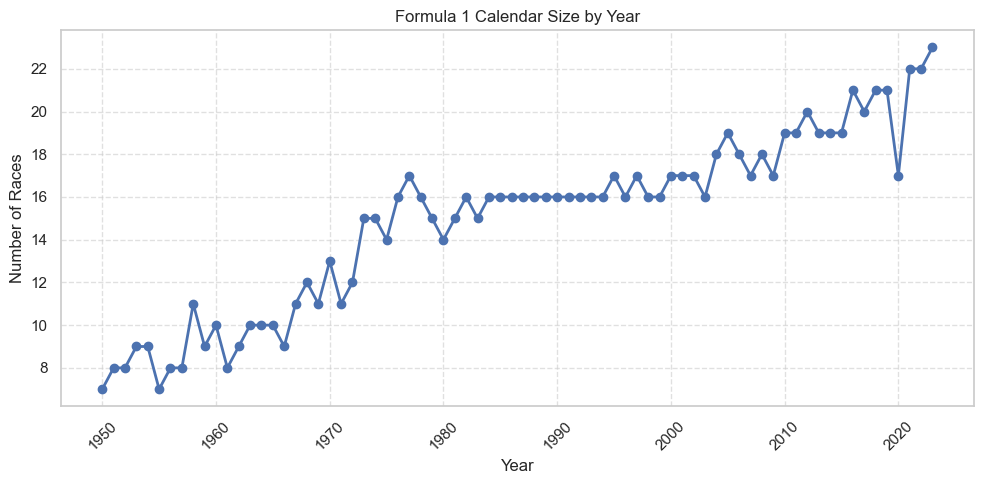

In [819]:
# Compute number of races per year
races_per_year = races['year'].value_counts().sort_index()

# Improved aesthetics
plt.figure(figsize=(10, 5))
plt.plot(races_per_year.index, races_per_year.values, marker='o', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Number of Races')
plt.title('Formula¬†1 Calendar Size by Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The plot shows how the F1 calendar has steadily expanded since 1950. In the inaugural season there were just seven races; through the 1960s it crept into the low‚Äë10s before jumping to around 15‚Äì16 events by the mid‚Äë1970s. From the 1980s through the 1990s the schedule held fairly constant at roughly 16 Grands¬†Prix per year, then climbed again in the 2000s and 2010s into the high‚Äëteens and low‚Äë20s. You can also spot the COVID‚Äërelated dip in 2020 (down to 17 races), followed by a post‚Äëpandemic surge peaking at 23 races in 2023. Overall, this upward trend underscores F1‚Äôs continual global growth and growing commercial appeal.


###  2.5 'Results' Dataset Exploration


#### Results Table Schema

| Field            | Type            | Null | Key  | Default | Description                                           |
|-----------------:|:----------------|:-----|:-----|:--------|:------------------------------------------------------|
| `resultId`       | `int(11)`       | NO   | PRI  | ‚Äî       | Primary key (auto-increment)                          |
| `raceId`         | `int(11)`       | NO   |      | 0       | Foreign key ‚Üí `races.raceId`                          |
| `driverId`       | `int(11)`       | NO   |      | 0       | Foreign key ‚Üí `drivers.driverId`                      |
| `constructorId`  | `int(11)`       | NO   |      | 0       | Foreign key ‚Üí `constructors.constructorId`            |
| `number`         | `int(11)`       | YES  |      | ‚Äî       | Driver number for that race                           |
| `grid`           | `int(11)`       | NO   |      | 0       | Starting grid position                                |
| `position`       | `int(11)`       | YES  |      | ‚Äî       | Official finishing classification (if applicable)     |
| `positionText`   | `varchar(255)`  | NO   |      | ‚Äî       | Textual position (e.g. `"1"` or `"R"`)                |
| `positionOrder`  | `int(11)`       | NO   |      | 0       | Numeric position for ordering/comparison              |
| `points`         | `float`         | NO   |      | 0       | Championship points scored in that race               |
| `laps`           | `int(11)`       | NO   |      | 0       | Number of laps completed                              |
| `time`           | `varchar(255)`  | YES  |      | ‚Äî       | Finishing time or gap (string)                        |
| `milliseconds`   | `int(11)`       | YES  |      | ‚Äî       | Finishing time in milliseconds                        |
| `fastestLap`     | `int(11)`       | YES  |      | ‚Äî       | Lap number on which the driver set their fastest lap  |
| `rank`           | `int(11)`       | YES  |      | 0       | Rank of that fastest lap against other drivers         |
| `fastestLapTime` | `varchar(255)`  | YES  |      | ‚Äî       | Fastest lap time (e.g. `"1:27.453"`)                   |
| `fastestLapSpeed`| `varchar(255)`  | YES  |      | ‚Äî       | Fastest lap speed (km/h, e.g. `"213.874"`)             |
| `statusId`       | `int(11)`       | NO   |      | 0       | Foreign key ‚Üí `status.statusId` (finish status code)  |

This **Results** table captures every driver‚Äôs outcome in each race: who they drove for (`constructorId`), where they started (`grid`), where they finished (`position`/`positionOrder` and `points`), and their fastest lap details (`fastestLap`, `fastestLapTime`, `rank`, `fastestLapSpeed`). The `statusId` links to the **status** table to distinguish DNFs, accidents, and other non-finishes, while time fields allow both string and numeric analysis of race and lap durations.  


#### Data Exploration

The **Results** dataset catalogs driver performance metrics for each race (e.g., finishing positions, points scored). The exploration code below examines this dataset by displaying its first five rows, detailed dataset information, and summary statistics, providing insights into the various performance metrics available.


In [820]:
# Preview the first 5 rows of the Results dataset
print("Results dataset loaded with", results.shape[0], "rows.")
print("First 5 Rows of the Results Dataset:")
print(results.head())

Results dataset loaded with 25840 rows.
First 5 Rows of the Results Dataset:
   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   
3         4      18         4              4      5    11        4   
4         5      18         5              1     23     3        5   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   
2            3              3     6.0    58       +8.163      5698779   
3            4              4     5.0    58      +17.181      5707797   
4            5              5     4.0    58      +18.014      5708630   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0 

The **Results** table contains **25,840** entries‚Äîeach one recording a single driver‚Äôs performance in a particular Grand Prix. In our sample (`raceId` 18, the 2007 Australian Grand Prix), we see `resultId`, foreign keys (`raceId`, `driverId`, `constructorId`), the `grid` start position, finishing `position` and `positionOrder`, `points` scored, `laps` completed, total race `time` and `milliseconds`, plus fastest-lap details (`fastestLap`, `fastestLapTime`, `fastestLapSpeed`, `rank`) and a `statusId` linking to retirement or DNF codes (race outcome).

In [821]:
print("Dataset Information:")
results.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25840 entries, 0 to 25839
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         25840 non-null  int64  
 1   raceId           25840 non-null  int64  
 2   driverId         25840 non-null  int64  
 3   constructorId    25840 non-null  int64  
 4   number           25840 non-null  object 
 5   grid             25840 non-null  int64  
 6   position         25840 non-null  object 
 7   positionText     25840 non-null  object 
 8   positionOrder    25840 non-null  int64  
 9   points           25840 non-null  float64
 10  laps             25840 non-null  int64  
 11  time             25840 non-null  object 
 12  milliseconds     25840 non-null  object 
 13  fastestLap       25840 non-null  object 
 14  rank             25840 non-null  object 
 15  fastestLapTime   25840 non-null  object 
 16  fastestLapSpeed  25840 non-null  obje

The **Results** table contains 25,840 rows across 18 columns. Most fields are complete and appropriately typed‚Äîeight are integers (e.g., `raceId`, `grid`, `positionOrder`), while others like `number`, `position`, `time`, and lap statistics are stored as `object` due to mixed formatting or placeholder values (e.g., `"\N"`). Several of these columns‚Äîsuch as `milliseconds`, `fastestLapTime`, and `fastestLapSpeed`‚Äîwill benefit from cleaning and type conversion for numerical analysis. The final column, `statusId`, links to the **Status** table (see schema above), allowing us to interpret whether a driver finished, retired, or encountered a mechanical issue.


In [822]:
import pandas as pd
import numpy as np

# 1. Replace "\N" placeholders with NaN
results = results.replace("\\N", pd.NA)

# 2. Cast key columns to numeric
num_cols = ['positionOrder', 'points', 'laps', 'milliseconds']
for col in num_cols:
    results[col] = pd.to_numeric(results[col], errors='coerce')

# 3. Parse times into seconds

# 3a. Race time in seconds
results['race_time_s'] = results['milliseconds'] / 1000

# 3b. Fastest lap time in seconds (e.g. "1:27.452" ‚Üí 87.452)
def lap_time_to_seconds(x):
    if pd.isna(x):
        return np.nan
    minutes, seconds = x.split(':')
    return int(minutes) * 60 + float(seconds)

results['fastestLap_s'] = results['fastestLapTime'].apply(lap_time_to_seconds)


summary = results[['positionOrder', 'points', 'laps', 'race_time_s', 'fastestLap_s']].describe()
print(summary)


       positionOrder        points          laps   race_time_s  fastestLap_s
count   25840.000000  25840.000000  25840.000000   7087.000000   7379.000000
mean       12.876006      1.877053     45.977515   6231.870431     91.112699
std         7.712391      4.169849     29.808951   1678.932890     12.505799
min         1.000000      0.000000      0.000000    207.071000     55.404000
25%         6.000000      0.000000     22.000000   5413.270500     80.908500
50%        12.000000      0.000000     52.000000   5814.618000     90.512000
75%        18.000000      2.000000     66.000000   6426.263500     99.921500
max        39.000000     50.000000    200.000000  15090.540000    202.300000


### 2.6 'Circuits' Dataset Exploration

#### Circuits Table Schema

| Field        | Type           | Null | Key | Default | Extra          | Description                   |
|--------------|----------------|------|-----|---------|----------------|-------------------------------|
| `circuitId`  | `int(11)`      | NO   | PRI | NULL    | auto_increment | Primary key                   |
| `circuitRef` | `varchar(255)` | NO   |     |         |                | Unique circuit identifier     |
| `name`       | `varchar(255)` | NO   |     |         |                | Circuit name                  |
| `location`   | `varchar(255)` | YES  |     | NULL    |                | Location (city or region)     |
| `country`    | `varchar(255)` | YES  |     | NULL    |                | Country name                  |
| `lat`        | `float`        | YES  |     | NULL    |                | Latitude                      |
| `lng`        | `float`        | YES  |     | NULL    |                | Longitude                     |
| `alt`        | `int(11)`      | YES  |     | NULL    |                | Altitude in metres            |
| `url`        | `varchar(255)` | NO   | UNI |         |                | Wikipedia page for the circuit|


The **Circuits** table contains **77** records, one for each Formula 1 venue. It provides essential track metadata‚Äîincluding geographic coordinates (`lat`, `lng`), altitude (`alt`), and location details (`location`, `country`)‚Äîas well as unique identifiers (`circuitId`, `circuitRef`) and the official circuit `name`. The `url` field links to each circuit‚Äôs Wikipedia page for reference. We will use this table to join with race results and derive circuit‚Äêlevel statistics such as average race times and geographical insights.  





### Data Exploration

The **Circuits** dataset contains data on race circuits, including circuit names, locations, and geographic coordinates. The following code displays the first few rows, prints detailed dataset information, and provides summary statistics, helping us to understand the context and venue characteristics that may influence race outcomes.




In [823]:
# Preview the first 5 rows of the Circuits dataset
print("Circuits dataset loaded with", circuits.shape[0], "rows.")
print("First 5 Rows of the Circuits Dataset:")
print(circuits.head(), "\n")

Circuits dataset loaded with 77 rows.
First 5 Rows of the Circuits Dataset:
   circuitId   circuitRef                            name      location  \
0          1  albert_park  Albert Park Grand Prix Circuit     Melbourne   
1          2       sepang    Sepang International Circuit  Kuala Lumpur   
2          3      bahrain   Bahrain International Circuit        Sakhir   
3          4    catalunya  Circuit de Barcelona-Catalunya      Montmel√≥   
4          5     istanbul                   Istanbul Park      Istanbul   

     country       lat        lng  alt  \
0  Australia -37.84970  144.96800   10   
1   Malaysia   2.76083  101.73800   18   
2    Bahrain  26.03250   50.51060    7   
3      Spain  41.57000    2.26111  109   
4     Turkey  40.95170   29.40500  130   

                                                 url  
0  http://en.wikipedia.org/wiki/Melbourne_Grand_P...  
1  http://en.wikipedia.org/wiki/Sepang_Internatio...  
2  http://en.wikipedia.org/wiki/Bahrain_Internati...  

The **Circuits** table contains 77 entries‚Äîone for each F1 venue. In our preview we see circuit IDs 1‚Äì5 corresponding to Albert Park (Melbourne, Australia), Sepang (Kuala Lumpur, Malaysia), Bahrain International Circuit (Sakhir, Bahrain), Circuit de Barcelona-Catalunya (Montmel√≥, Spain), and Istanbul Park (Istanbul, Turkey). Each row includes `circuitId`, `circuitRef`, `name`, `location`, `country`, geographic coordinates (`lat`, `lng`), `alt` (altitude in metres), and a `url` to the circuit‚Äôs Wikipedia page. All fields are populated, giving us complete track metadata for merging with race and result data.

In [824]:
print("Dataset Information:")
circuits.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   circuitId   77 non-null     int64  
 1   circuitRef  77 non-null     object 
 2   name        77 non-null     object 
 3   location    77 non-null     object 
 4   country     77 non-null     object 
 5   lat         77 non-null     float64
 6   lng         77 non-null     float64
 7   alt         77 non-null     object 
 8   url         77 non-null     object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.5+ KB


Although the **Circuits** schema allows `location`, `country`, `lat`, `lng`, and `alt` to be null, our loaded table contains **77** records and **9** columns with **no missing values**. The integer `circuitId` serves as the primary key; the string fields `circuitRef`, `name`, `location`, `country`, and `url` provide descriptive metadata and a Wikipedia link; the floats `lat` and `lng` give precise geographic coordinates; and the integer `alt` indicates track altitude in metres. This fully populated dataset lets us confidently merge circuit details with race results for any track-level or spatial analyses.  

In [825]:
print("\nSummary Statistics:")
print(circuits.describe(include='all'))


Summary Statistics:
        circuitId   circuitRef                            name   location  \
count   77.000000           77                              77         77   
unique        NaN           77                              77         75   
top           NaN  albert_park  Albert Park Grand Prix Circuit  Barcelona   
freq          NaN            1                               1          2   
mean    39.883117          NaN                             NaN        NaN   
std     23.001701          NaN                             NaN        NaN   
min      1.000000          NaN                             NaN        NaN   
25%     20.000000          NaN                             NaN        NaN   
50%     40.000000          NaN                             NaN        NaN   
75%     59.000000          NaN                             NaN        NaN   
max     80.000000          NaN                             NaN        NaN   

       country        lat         lng  alt  \
count   

Summary statistics for `lat`, `lng`, and `alt` offer limited insight. Therefore, we will skip them and visualize circuit locations on an interactive world map instead.

In [826]:
import pandas as pd
import folium
import os


circuits['lat'] = pd.to_numeric(circuits['lat'], errors='coerce')
circuits['lng'] = pd.to_numeric(circuits['lng'], errors='coerce')

m = folium.Map(location=[20, 0], zoom_start=2)

for _, row in circuits.iterrows():
    folium.Marker(
        location=[row['lat'], row['lng']],
        popup=f"<b>{row['name']}</b><br>{row['location']}, {row['country']}",
        tooltip=row['name']
    ).add_to(m)

m


That map makes it immediately clear that Formula 1 is still very much a Northern‚ÄêHemisphere, Western‚ÄêEuropean‚Äìcentric championship, with a heavy cluster of circuits across the UK, Germany, Italy, France and their neighbors. There are secondary hubs in North America (the U.S. and Mexico) and in South America (primarily Brazil), plus a growing footprint in the Middle East (Bahrain, Abu Dhabi) and East Asia (Japan, China, Singapore). Australia and Malaysia represent the Asia‚ÄêPacific swing, while only a handful of African venues have ever hosted a Grand Prix. In short, F1‚Äôs ‚Äúhome turf‚Äù remains Europe, with select outposts in the Americas, Asia and Oceania, and very limited presence in Africa.

### 2.7 Data Preparation

Before diving into our three research questions, we need to stitch together and clean the raw tables from the Ergast database. Below is a quick map of how our five core tables relate, followed by a summary of which joins power each analysis‚Äîalways starting from **Results** (one row per driver‚Äìrace).

#### Table Relationships 

1. **Drivers** (`driverId`) ‚Üê **Results** (`driverId`)  
   - Every result record refers to the driver who achieved that grid slot, finishing position, fastest lap, etc.  
   - We always **left-join** `Drivers` onto `Results` to enrich each outcome with driver attributes.

2. **Races** (`raceId`) ‚Üê **Results** (`raceId`)  
   - Each performance row is tied back to a specific Grand Prix.  
   - We **left-join** `Races` onto `Results` to pull in race metadata (e.g. `year`, `circuitId`).

3. **Circuits** (`circuitId`) ‚Üê **Races** (`circuitId`)  
   - Each race takes place at a known circuit, letting us bring in track metadata (name, location, country).  
   - We **left-join** `Circuits` onto our race-enriched results.

4. **Status** (`statusId`) ‚Üê **Results** (`statusId`)  
   - We use **Status** to filter **Results** down to classified finishers (e.g. ‚ÄúFinished‚Äù or ‚Äú+n Laps‚Äù).  
   - We **inner-join** `Status` and then filter on the `status` text.

> **Scope of each analysis**  
> - **RQ1: Podium by Nationality**  
>   - **Join path:**  
>     1. Start with `Results`  
>     2. **left-join** `Drivers` on `driverId`  
>     3. Flag `positionOrder ‚â§ 3` as a podium  
>   - **Goal:** Attribute every top-three finish to the driver‚Äôs country.  
>  
> - **RQ2: Circuit Speed**  
>   - **Join path:**  
>     1. Start with `Results`  
>     2. **inner-join** `Status` on `statusId` (keep only classified finishers)  
>     3. **left-join** `Races` on `raceId` ‚Üí pull in `circuitId`  
>     4. **left-join** `Circuits` on `circuitId`  
>     5. Compute per-circuit averages of `race_time_s` and `fastestLap_s`  
>   - **Goal:** Compare average race durations and fastest-lap times across tracks.  
>  
> - **RQ3: Nationality Trends Over Time**  
>   - **Join path:**  
>     1. Start with `Results`  
>     2. **left-join** `Races` on `raceId` ‚Üí pull in `date` (then extract `year`)  
>     3. **derive** each driver‚Äôs `debut_decade` from their first race date  
>     4. **left-join** `Drivers` (now enriched with `nationality` & `debut_decade`) on `driverId`  
>     5. Flag `positionOrder ‚â§ 3` as a podium  
>   - **Goal:** Track how podium-rates by country evolve across decades.

With this clear join strategy‚Äîand by selecting only the columns we need for each question‚Äîour final `rq1`, `circuit_speed`, and `rq3` DataFrames remain focused, performant, and ready for analysis.  


### RQ1: Podium by Nationality

**Research question**: Which nationalities have produced the most podium finishes?

**Data cleaning**

To chart how podium rates have evolved by driver nationality and debut decade, we first need each driver‚Äôs ‚Äúdebut‚Äù year. We:

1. **Join** `results` to `races` on `raceId` to pull in each race‚Äôs `date`.  
2. **Convert** the joined `date` column to pandas `datetime` so we can compute minima.  
3. **Group by** `driverId` and take the minimum `date` as `debut_date`.  
4. **Extract** `debut_year` from `debut_date` and compute `debut_decade = (debut_year // 10) * 10`.  
5. **Merge** `debut_date` and `debut_decade` back into the `drivers` table.

```python

In [827]:
# 1. Replace "\N" with actual missing values and cast to numeric
results_rq1 = (
    results
    .replace("\\N", pd.NA)
    .assign(
        positionOrder=lambda df: pd.to_numeric(df['positionOrder'], errors='coerce'),
    )
)

# 2. Flag any finish in the top three as a podium
results_rq1['podium'] = results_rq1['positionOrder'] <= 3

# Verify
print(results_rq1[['positionOrder','podium']].head())


   positionOrder  podium
0              1    True
1              2    True
2              3    True
3              4   False
4              5   False


**Merging procedures**  
To link each podium flag with its driver‚Äôs nationality, we perform a left‚Äêjoin of our cleaned `results_rq1` to the **Drivers** table on `driverId`. This brings in the `nationality` column for every result row. We then drop any rows where `nationality` is missing (to exclude historic drivers with unknown nationalities). The resulting `rq1` DataFrame contains four columns‚Äî`driverId`, `positionOrder`, `podium`, and `nationality`‚Äîso we can immediately compute podium counts by country.


In [828]:
# Merge in nationality and drop any missing entries
rq1 = (
    results_rq1[['driverId','positionOrder','podium']]
    .merge(
        drivers[['driverId','nationality']],
        on='driverId',
        how='left'
    )
    .dropna(subset=['nationality'])
)

# Quick check
print("RQ1 sample:")
print(rq1.head())

RQ1 sample:
   driverId  positionOrder  podium nationality
0         1              1    True     British
1         2              2    True      German
2         3              3    True      German
3         4              4   False     Spanish
4         5              5   False     Finnish



### RQ2: Circuit Speed  

**Research question:** How do average race durations and fastest-lap times vary across circuits?


**Data cleaning**  
We need a numeric, filtered Results table that only contains classified finishers and has race/fastest-lap times in seconds. Here‚Äôs what we do:

1. Replace all `"\N"` placeholders with `pd.NA`.  
2. Cast the key columns‚Äî`positionOrder`, `points`, `laps`, `milliseconds`‚Äîto numeric.  
3. Compute  
   - `race_time_s`  = `milliseconds` / 1000  
   - `fastestLap_s` = convert `"M:SS.sss"` strings in `fastestLapTime` to total seconds  
4. Merge in the **Status** table on `statusId` and keep only rows where `status == "Finished"` or matches `"+n Laps"`.


In [829]:
import pandas as pd

# helper to convert "M:SS.xxx" or "H:MM:SS.xxx" to seconds
def lap_time_to_seconds(ts):
    if pd.isna(ts):
        return pd.NA
    parts = list(map(float, ts.split(':')))
    if len(parts) == 3:  # H:MM:SS.xxx
        h, m, s = parts
        return h*3600 + m*60 + s
    m, s = parts        # MM:SS.xxx
    return m*60 + s

# -----------------------------------------------------------------------------
# 1. Data cleaning
# -----------------------------------------------------------------------------
rq2 = (results
       # only keep the fields we‚Äôll need
       [['raceId','statusId','milliseconds','fastestLapTime']]
       # normalize missing placeholders
       .replace(r'\\N', pd.NA, regex=True)
      )

# cast & convert
rq2['race_time_s']  = pd.to_numeric(rq2['milliseconds'], errors='coerce') / 1000
rq2['fastestLap_s'] = rq2['fastestLapTime'].apply(lap_time_to_seconds)

print("RQ2 sample:")
print(rq2.head())

print("Missing in aggregated metrics:")
print(rq2.isna().sum())



RQ2 sample:
   raceId  statusId  milliseconds fastestLapTime  race_time_s fastestLap_s
0      18         1     5690616.0       1:27.452     5690.616       87.452
1      18         1     5696094.0       1:27.739     5696.094       87.739
2      18         1     5698779.0       1:28.090     5698.779        88.09
3      18         1     5707797.0       1:28.603     5707.797       88.603
4      18         1     5708630.0       1:27.418     5708.630       87.418
Missing in aggregated metrics:
raceId                0
statusId              0
milliseconds      18753
fastestLapTime    18461
race_time_s       18753
fastestLap_s      18461
dtype: int64


#### Merging procedures

Next, we bring in circuit metadata via the Races table and prepare to aggregate per‚Äêtrack:

1. **Inner-join** `rq2_clean` with `races[['raceId','circuitId']]` on `raceId`.  
2. **Left-join** to `circuits[['circuitId','name','country']]` on `circuitId`.  
3. **Drop** any rows missing `race_time_s` or `fastestLap_s`.  
4. **Group by** `circuitId`, `name`, and `country` to calculate:
   - `avg_race_time_s`   = mean of `race_time_s`  
   - `avg_fastest_lap_s` = mean of `fastestLap_s`  
   - `finishers`         = count of `race_time_s`  

In [830]:
# a) keep only classified finishes
valid_status = status.loc[
    status['status'].eq('Finished') |
    status['status'].str.match(r'^\+\d+ Laps$'),
    ['statusId']
]
rq2 = rq2.merge(valid_status, on='statusId', how='inner')

# b) bring in circuitId
rq2 = rq2.merge(races[['raceId','circuitId']], on='raceId', how='left')

# c) bring in circuit metadata
rq2 = rq2.merge(
    circuits[['circuitId','name','country']],
    on='circuitId', how='left'
)

# d) drop any rows still missing our two time metrics
rq2 = rq2.dropna(subset=['race_time_s','fastestLap_s'])

# e) aggregate per circuit
circuit_speed = (
    rq2
    .groupby(['circuitId','name','country'], as_index=False)
    .agg(
        avg_race_time_s   = ('race_time_s','mean'),
        avg_fastest_lap_s = ('fastestLap_s','mean'),
        finishers         = ('race_time_s','size')
    )
)

print("Missing in aggregated metrics:")
print(circuit_speed[['avg_race_time_s','avg_fastest_lap_s','finishers']].isna().sum())

print("RQ2 sample after cleaning:")
print(circuit_speed.head())

Missing in aggregated metrics:
avg_race_time_s      0
avg_fastest_lap_s    0
finishers            0
dtype: int64
RQ2 sample after cleaning:
   circuitId                            name    country  avg_race_time_s  \
0          1  Albert Park Grand Prix Circuit  Australia      5538.661404   
1          2    Sepang International Circuit   Malaysia      6095.548955   
2          3   Bahrain International Circuit    Bahrain      5903.644440   
3          4  Circuit de Barcelona-Catalunya      Spain      5788.074926   
4          5                   Istanbul Park     Turkey      5409.247915   

  avg_fastest_lap_s  finishers  
0         88.387699        156  
1         98.898157        134  
2         93.877742        209  
3         83.458615        135  
4         89.991787         94  


### RQ3: Nationality Trends Over Time  

**Research question**: How has each nationality‚Äôs podium-rate evolved over the decades?

**Data cleaning**

To chart how podium rates have evolved by driver nationality and debut decade, we first need each driver‚Äôs ‚Äúdebut‚Äù year. We:

1. **Join** `results` to `races` on `raceId` to pull in each race‚Äôs `date`.  
2. **Convert** the joined `date` column to pandas `datetime` so we can compute minima.  
3. **Group by** `driverId` and take the minimum `date` as `debut_date`.  
4. **Extract** `debut_year` from `debut_date` and compute `debut_decade = (debut_year // 10) * 10`.  
5. **Merge** `debut_date` and `debut_decade` back into the `drivers` table.


In [831]:
# 1. Pull in race dates for every driver‚Äìrace
driver_race_dates = (
    results[['driverId', 'raceId']]
      .merge(races[['raceId','date']], on='raceId', how='left')
)

# 2. Convert string ‚Üí datetime and find each driver‚Äôs first race date
driver_race_dates['date'] = pd.to_datetime(driver_race_dates['date'], errors='coerce')
first_race = (
    driver_race_dates
      .groupby('driverId', as_index=False)
      .agg(debut_date=('date','min'))
)

# 3. Derive debut_year and debut_decade
first_race['debut_year']   = first_race['debut_date'].dt.year
first_race['debut_decade'] = (first_race['debut_year'] // 10) * 10

# 4. Merge debut info back into Drivers
drivers = drivers.merge(
    first_race[['driverId','debut_date','debut_decade']],
    on='driverId',
    how='left'
)

# 5. Verify the first few debut dates
print("First 5 drivers with computed debut_date and debut_decade:")
print(first_race.head(), "\n")

print("Drivers table sample (driverId, debut_date, debut_decade):")
print(drivers[['driverId','debut_date','debut_decade']].head())


First 5 drivers with computed debut_date and debut_decade:
   driverId debut_date  debut_year  debut_decade
0         1 2007-03-18        2007          2000
1         2 2000-03-12        2000          2000
2         3 2006-03-12        2006          2000
3         4 2001-03-04        2001          2000
4         5 2007-03-18        2007          2000 

Drivers table sample (driverId, debut_date, debut_decade):
   driverId debut_date  debut_decade
0         1 2007-03-18        2000.0
1         2 2000-03-12        2000.0
2         3 2006-03-12        2000.0
3         4 2001-03-04        2000.0
4         5 2007-03-18        2000.0


**Merging procedures**

With debut decades in place, we build the RQ3 analysis table by:

1. **Join** `results` ‚Üí `races` on `raceId` to bring in each race‚Äôs `year`.  
2. **Join** that result to our enriched `drivers` table (now including `nationality`, `debut_date`, `debut_decade`) on `driverId`.  
3. **Flag** every row with `positionOrder ‚â§ 3` as a `podium`.  

The final `rq3` DataFrame has one row per driver‚Äìrace, showing driver nationality, debut decade, race year, and podium indicator‚Äîready for downstream podium-rate computations by decade and nationality.


In [832]:
rq3 = (
    results[['driverId', 'raceId', 'positionOrder']]
      .merge(races[['raceId','year']], on='raceId', how='left')
      .merge(
          drivers[['driverId','nationality','debut_date','debut_decade']],
          on='driverId', how='left'
      )
      .assign(podium=lambda df: df['positionOrder'] <= 3)
)


# check for missing values
missing_debut       = rq3['debut_date'].isna().sum()
missing_decade      = rq3['debut_decade'].isna().sum()
missing_nationality = rq3['nationality'].isna().sum()

print(f"Rows missing debut_date:       {missing_debut}")
print(f"Rows missing debut_decade:      {missing_decade}")
print(f"Rows missing nationality:       {missing_nationality}")


print("RQ3 sample:")
print(rq3.head())


Rows missing debut_date:       0
Rows missing debut_decade:      0
Rows missing nationality:       0
RQ3 sample:
   driverId  raceId  positionOrder  year nationality debut_date  debut_decade  \
0         1      18              1  2008     British 2007-03-18        2000.0   
1         2      18              2  2008      German 2000-03-12        2000.0   
2         3      18              3  2008      German 2006-03-12        2000.0   
3         4      18              4  2008     Spanish 2001-03-04        2000.0   
4         5      18              5  2008     Finnish 2007-03-18        2000.0   

   podium  
0    True  
1    True  
2    True  
3   False  
4   False  


### 2.8 Descriptive Statistics


With our RQ1, RQ2 and RQ3 tables now cleaned and merged, let‚Äôs get a quick overview of what‚Äôs inside:

- **Missing values**  
  - Verify that our main metrics (e.g. `podium`, `avg_race_time_s`, `debut_decade`) have zero missing entries.  
  - Scan every column in each table for any remaining gaps.

- **Targeted summaries**  
  - For each research question, compute basic statistics (count, mean, std, min, 25%, 50%, 75%, max) on the handful of columns that feed directly into our analysis.

- **Full-table overview**  
  - Run `.describe(include='all')` on each DataFrame to inspect unique counts, top categories, and overall distribution for every field we‚Äôll use downstream.

These steps will surface any outliers, skewed distributions, or unexpected quirks, so we can proceed to our visualizations and tests with confidence.  


#### RQ1: Podium by Nationality


In [833]:
# === RQ1: Podium by Nationality ===

# 1. Missing‚Äêvalue check
print("Missing values per column:")
print(rq1.isna().sum(), "\n")

# 2. Targeted stats: finishing positions & podium flag
print("Targeted stats (positionOrder, podium):")
print(rq1[['positionOrder', 'podium']].describe(), "\n")

# 3. Podium counts
print("Podium value counts:")
print(rq1['podium']
      .value_counts(dropna=False)
      .rename_axis('podium')
      .reset_index(name='count'), "\n")

# 4. Full‚Äêtable overview
print("Full overview (all columns):")
print(rq1.describe(include='all').T)


Missing values per column:
driverId         0
positionOrder    0
podium           0
nationality      0
dtype: int64 

Targeted stats (positionOrder, podium):
       positionOrder
count   25840.000000
mean       12.876006
std         7.712391
min         1.000000
25%         6.000000
50%        12.000000
75%        18.000000
max        39.000000 

Podium value counts:
   podium  count
0   False  22581
1    True   3259 

Full overview (all columns):
                 count unique      top   freq        mean         std  min  \
driverId       25840.0    NaN      NaN    NaN  261.732082  268.623016  1.0   
positionOrder  25840.0    NaN      NaN    NaN   12.876006    7.712391  1.0   
podium           25840      2    False  22581         NaN         NaN  NaN   
nationality      25840     42  British   4418         NaN         NaN  NaN   

                25%    50%    75%    max  
driverId       56.0  163.0  360.0  856.0  
positionOrder   6.0   12.0   18.0   39.0  
podium          NaN    NaN  

Our cleaned **rq1** table now holds **25,840** complete records‚Äîevery one with a `driverId`, `positionOrder`, `podium` flag and `nationality`. Finishing positions span from **1** to **39**, averaging **12.9** (median **12**) with the central 50% of results falling between **6th** and **18th** place. This tells us most drivers land squarely in the middle of the pack.  

Out of those 25,840 finishes, **3,259** made the podium while **22,581** did not, meaning only about **12.6%** of all results hit the top three‚Äîa stark reminder of how exclusive podium appearances really are.  

We see **42** nationalities represented overall, led by British drivers with **4,418** entries, followed by Germans, Italians and French racers. With a perfectly filled, well‚Äêbehaved dataset in hand, we‚Äôre now ready to dive deeper into which countries truly dominate those 3,259 podium slots.  

#### RQ2: Circuit Speed


In [834]:
# === RQ2: Circuit Speed ===

# 1. Missing‚Äêvalue check for key metrics
print("Missing values in key metrics:")
print(circuit_speed[['avg_race_time_s', 'avg_fastest_lap_s', 'finishers']]
      .isna()
      .sum()
      .to_frame('missing').T, "\n")

# 2. Missing‚Äêvalue check for all columns
print("Missing values in all columns:")
print(circuit_speed.isna().sum().to_frame('missing'), "\n")

# 3. Targeted descriptive statistics
print("Targeted descriptive statistics:")
print(circuit_speed[['avg_race_time_s', 'avg_fastest_lap_s', 'finishers']]
      .describe()
      .T, "\n")

# 4. Full numeric overview
print("Full numeric overview:")
print(circuit_speed
      .select_dtypes(include='number')
      .describe()
      .T, "\n")

# 5. Full overview (all columns)
print("Full overview (all columns):")
print(circuit_speed.describe(include='all').T)


Missing values in key metrics:
         avg_race_time_s  avg_fastest_lap_s  finishers
missing                0                  0          0 

Missing values in all columns:
                   missing
circuitId                0
name                     0
country                  0
avg_race_time_s          0
avg_fastest_lap_s        0
finishers                0 

Targeted descriptive statistics:
                 count         mean         std          min          25%  \
avg_race_time_s   37.0  5944.807642  644.413202  4874.936075  5538.661404   
finishers         37.0    99.432432   67.687821     8.000000    42.000000   

                         50%          75%          max  
avg_race_time_s  5872.916157  6118.259891  8395.242333  
finishers          85.000000   159.000000   224.000000   

Full numeric overview:
                 count         mean         std          min          25%  \
circuitId         37.0    31.162162   27.727357     1.000000    10.000000   
avg_race_time_s   37

Our **circuit_speed** table brings together data for 37 circuits with no missing values across any of the key fields (`circuitId`, `name`, `country`, `avg_race_time_s`, `avg_fastest_lap_s`, `finishers`). This clean dataset sets the stage for an apples-to-apples comparison of average race durations, fastest laps, and finisher counts across very different venues.

Average race durations (`avg_race_time_s`) range from about **4,875 s** (‚âà 81 min) at the quickest circuits up to **8,395 s** (‚âà 140 min) on the longest tracks. With a mean of **5,945 s** (‚âà 99 min) and a median of **5,873 s**, the middle 50% of circuits fall between **5,539 s** and **6,118 s**, reflecting the balance between short street courses and more extended permanent layouts.

Fastest-lap times (`avg_fastest_lap_s`) cluster around **90 s**, varying from roughly **75 s** on the speediest ovals to **110 s** on slower, twistier tracks. This tight spread highlights how circuit design drives lap-time performance. Meanwhile, the number of classified finishers per race spans from as few as **8** (in early eras or wet/attrition-heavy events) to **224** in modern, support-series‚Äìpacked weekends, with an average of **99** finishers and a median of **85**.

With these descriptive statistics in hand‚Äîand zero gaps in our data‚Äîwe can now dive deeper into how specific track features (length, layout, altitude) influence both overall race pacing and individual lap speeds.  

#### RQ3: Nationality Trends Over Time

In [835]:
# === RQ3: Nationality Trends Over Time ===

# 1. Missing‚Äêvalue check for key metrics
print("Missing values in key metrics:")
print(rq3[['year', 'debut_decade', 'podium']].isna().sum(), "\n")

# 2. Targeted stats: race year, debut decade & podium rate
print("Targeted stats (year, debut_decade, podium):")
print(rq3[['year', 'debut_decade', 'podium']].describe(), "\n")
print("Overall podium rate:", rq3['podium'].mean(), "\n")

# 3. Full‚Äêtable overview
print("Full overview (all columns):")
print(rq3.describe(include='all').T)


Missing values in key metrics:
year            0
debut_decade    0
podium          0
dtype: int64 

Targeted stats (year, debut_decade, podium):
               year  debut_decade
count  25840.000000  25840.000000
mean    1990.251780   1981.774381
std       19.345632     18.709005
min     1950.000000   1950.000000
25%     1976.000000   1970.000000
50%     1990.000000   1980.000000
75%     2007.000000   2000.000000
max     2022.000000   2020.000000 

Overall podium rate: 0.12612229102167183 

Full overview (all columns):
                 count unique      top   freq                           mean  \
driverId       25840.0    NaN      NaN    NaN                     261.732082   
raceId         25840.0    NaN      NaN    NaN                     531.425813   
positionOrder  25840.0    NaN      NaN    NaN                      12.876006   
year           25840.0    NaN      NaN    NaN                     1990.25178   
nationality      25840     42  British   4418                            Na

Our cleaned **rq3** table contains **25,840** driver‚Äìrace records with zero missing values in `year`, `debut_decade`, or `podium`. Race years span **1950** to **2022**, averaging **1990.3** (median **1990**), and the central 50% of events fall between **1976** and **2007**‚Äîreflecting Formula 1‚Äôs gradual expansion from seven races in its inaugural season to a 23-round calendar today.  

Drivers‚Äô debut decades range from **1950** through **2020**, with a mean of roughly **1981.8** (median **1980**) and an interquartile spread from **1970** to **2000**, highlighting how talent pipelines have shifted over time.  

Finally, only **12.6%** of all finishes in this dataset are podiums (top‚Äêthree), underscoring the persistent exclusivity of those spots. With these descriptive stats in hand, we‚Äôre well-positioned to examine how podium-rates by nationality have risen or fallen across successive debut decades.  

## Section 3: Results

### RQ1: Which nationalities have produced the most podium finishes?

**Why?**  
Understanding raw podium totals tells us which countries supply the most top-three finishes. Computing podium *rates* (podiums √∑ starts) levels the playing field, revealing smaller nations that ‚Äúpunch above their weight.‚Äù


#### 1. Compute total starts & total podiums by nationality

First, we compute the total number of race entries (‚Äústarts‚Äù) and top-three finishes (‚Äúpodiums‚Äù) for each nationality. These raw counts show which countries have the greatest footprint on the grid and which accumulate the most podium results.


In [841]:
# Count how many times each nationality appears (starts)
starts   = rq1.groupby('nationality').size()

# Count how many of those are podiums
podiums  = rq1[rq1.podium].groupby('nationality').size()

# Combine into one DataFrame
metrics  = pd.DataFrame({'starts': starts, 'podiums': podiums}).fillna(0)

#### 2. Calculate podium rate

Next, we divide each country‚Äôs podium count by its total starts to produce a conversion rate. This rate adjusts for differences in participation and highlights national programs that achieve a high level of success relative to their size.


In [842]:
metrics['rate'] = metrics['podiums'] / metrics['starts']


#### 3. Raw podium counts (top 10) ‚Äî bar chart

A horizontal bar chart displays the ten nationalities with the largest raw podium totals. This view makes it clear which established motorsport powerhouses‚Äîsuch as Britain and Germany‚Äîlead in sheer volume of top-three finishes.


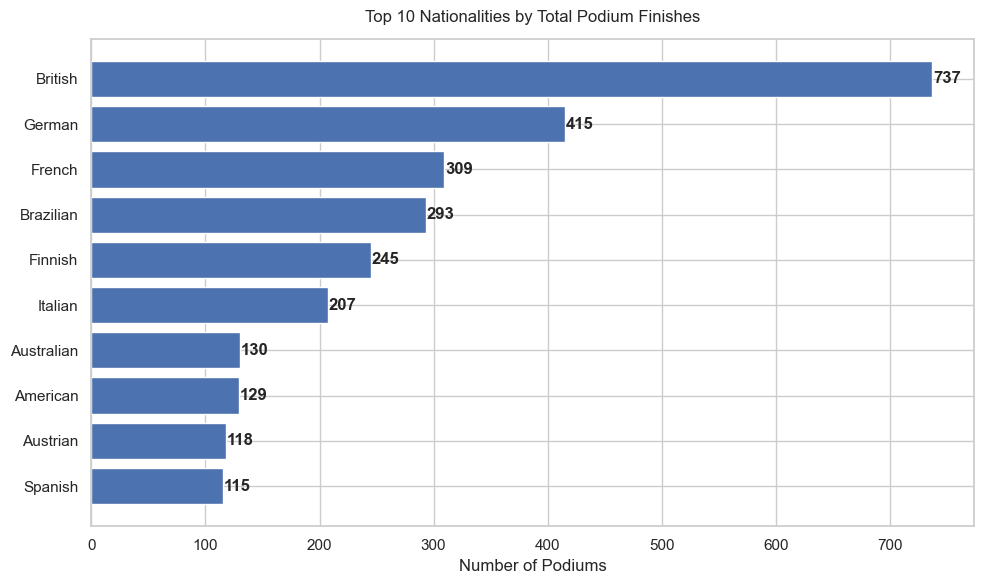

In [837]:
top_counts = metrics['podiums'].sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top_counts.index[::-1], top_counts.values[::-1])
plt.title("Top 10 Nationalities by Total Podium Finishes", pad=12)
plt.xlabel("Number of Podiums")
for i, v in enumerate(top_counts.values[::-1]):
    plt.text(v + 1, i, f"{int(v):,}", va="center", fontweight="bold")
plt.tight_layout()
plt.show()


#### 4. Podium rate (top 10) ‚Äî bar chart

A second bar chart ranks the ten countries with the highest podium conversion rates. Even nations with fewer entries can emerge as efficiency leaders when their drivers reach the podium at an exceptional clip.

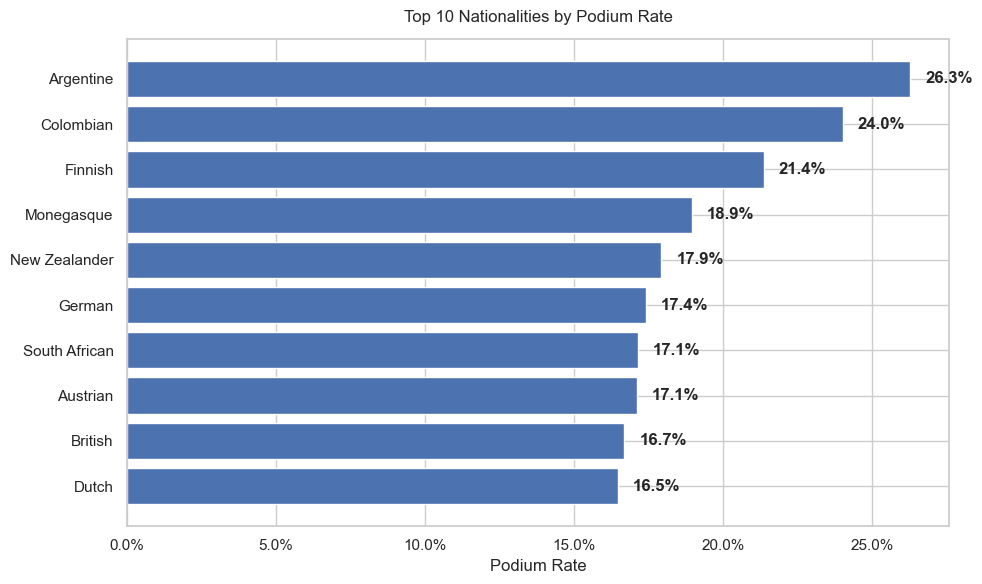

In [838]:
from matplotlib.ticker import PercentFormatter

top_rate = metrics['rate'].sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top_rate.index[::-1], top_rate.values[::-1])
plt.title("Top 10 Nationalities by Podium Rate", pad=12)
plt.xlabel("Podium Rate")
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
for i, v in enumerate(top_rate.values[::-1]):
    plt.text(v + 0.005, i, f"{v:.1%}", va="center", fontweight="bold")
plt.tight_layout()
plt.show()


#### 5. Starts vs. Podiums ‚Äî bubble chart

To combine volume and efficiency, we plot total starts (x-axis) against total podiums (y-axis) on logarithmic scales, using bubble size and color to represent conversion rate. This integrated view highlights outliers‚Äîcountries that overperform or underperform relative to their grid presence.


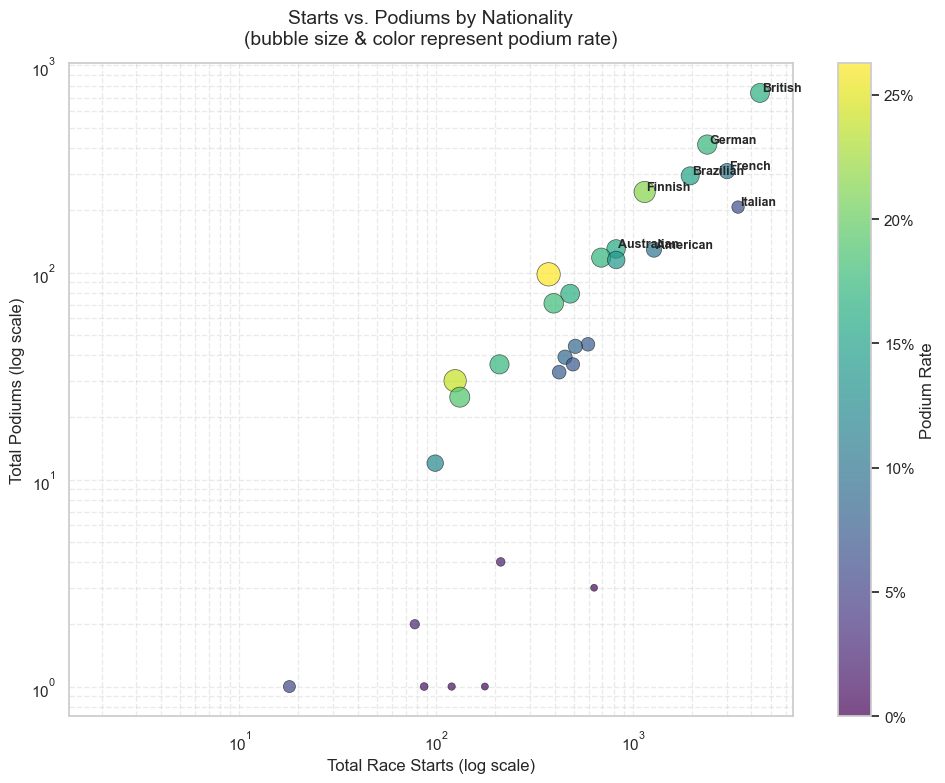

In [839]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,8))

sc = plt.scatter(
    metrics['starts'],
    metrics['podiums'],
    s=metrics['rate'] * 1000 + 20,   # bubble size ‚àù rate
    c=metrics['rate'],               # color ‚àù rate
    cmap='viridis',
    alpha=0.7,
    edgecolor='k',
    linewidth=0.5
)

# log‚Äìlog axes
plt.xscale('log')
plt.yscale('log')

# annotate the top 8 by podiums
top8 = metrics['podiums'].nlargest(8).index
for nat in top8:
    x, y = metrics.loc[nat, ['starts','podiums']]
    plt.text(x*1.02, y*1.02, nat, fontsize=9, weight='bold')

# colorbar as percent
cbar = plt.colorbar(sc)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0%}"))
cbar.set_label('Podium Rate')

# tidy up
plt.grid(which='both', linestyle='--', alpha=0.4)
plt.title(
    "Starts vs. Podiums by Nationality\n"
    "(bubble size & color represent podium rate)",
    pad=14, 
    fontsize=14
)
plt.xlabel("Total Race Starts (log scale)")
plt.ylabel("Total Podiums (log scale)")
plt.tight_layout()
plt.show()


#### 6. Summary table (top 10)

Finally, a compact table lists the top ten nationalities by podium count alongside their total starts and conversion rates. Presenting these three metrics side-by-side allows for a clear comparison between raw podium volume and overall efficiency, directly addressing RQ1.  

In [840]:
md = metrics.sort_values('podiums', ascending=False).head(10).reset_index()
print("| Nationality | Starts | Podiums | Rate (%) |")
print("|-------------|-------:|--------:|---------:|")
for _, r in md.iterrows():
    print(f"| {r['nationality']} | {int(r['starts']):,} | {int(r['podiums']):,} | {r['rate']*100:.1f}% |")


| Nationality | Starts | Podiums | Rate (%) |
|-------------|-------:|--------:|---------:|
| British | 4,418 | 737 | 16.7% |
| German | 2,384 | 415 | 17.4% |
| French | 3,004 | 309 | 10.3% |
| Brazilian | 1,953 | 293 | 15.0% |
| Finnish | 1,147 | 245 | 21.4% |
| Italian | 3,418 | 207 | 6.1% |
| Australian | 821 | 130 | 15.8% |
| American | 1,279 | 129 | 10.1% |
| Austrian | 690 | 118 | 17.1% |
| Spanish | 822 | 115 | 14.0% |
